In [1]:
import os
repo_dir = os.environ.get("REPO_DIR")
code_dir = os.path.join(repo_dir, "code/")
data_dir = os.path.join(repo_dir, "data/")
os.chdir(code_dir)

import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import pickle
import sklearn 
import sys
import pandas as pd
import cartopy.crs as ccrs

import seaborn as sns

import geopandas as gpd

from scipy.stats import truncnorm

import matplotlib.patches as mpatches

In [2]:
#matplotlib.rc('font', **{'size'   : 22})

In [3]:
col = matplotlib.cm.get_cmap('plasma')

adm1_color = col(0.15)
adm2_color = col(0.66)

## Text save setting for AI
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

In [4]:
def drop_at_random_for_quota(arr, quota):
    """
    Takes an array of booleans and ensure that the number of truth (targeted) matches a quota
    
    In effect, some boolean values are randomly set to False.
    
    """
    assert all([isinstance(item,np.bool_) or isinstance(item, bool)  for item in arr]), "wrong format for function"
    diff = int((arr.sum() - quota))
    if diff <= 0:
        print("unexpected input")
        raise Exception
    target_idxs = np.where(arr)[0]
    unlucky = np.random.choice(target_idxs,size=diff, replace=False)
    arr[unlucky] = False
    return arr
    

In [5]:
data = pd.read_pickle(data_dir + "preds/mexico_pred_and_observed.p").rename(columns = {
    "total_pop":"population", "mhdi" : "mhdi_adm2 true"})

In [6]:
downscale = 100

In [7]:
data["pop_downscale"] = (data["population"]/downscale).round().astype(int)

In [8]:
num_people = data["pop_downscale"].sum()

In [9]:
poor_quantile = 0.1 ## These can be set differently for imperfect specificity
target_quantile = 0.1

target_pop = (target_quantile * num_people).round().astype(int)
poor_pop = (poor_quantile * num_people).round().astype(int)

In [10]:
target_pop

123389

### Begin simulation

#### Create truth and assumed

In [11]:
from sklearn.metrics import roc_auc_score, roc_curve,RocCurveDisplay
from sklearn.linear_model import LogisticRegression

In [12]:
assumed_true_SDs = [0.05,0.1,0.2,0.3]

In [13]:
print_additional_text = True

In [14]:
#assumed_true_SDs = [0.1]

In [15]:
from matplotlib.ticker import FuncFormatter
def millions(x, pos):
    'The two args are the value and tick position'
    return '%1.fM' % (x * 1e-6 *downscale)


formatter = FuncFormatter(millions)

tp_adm1: 40.78078272779583
tp_adm2: 52.871811911920844
tp_adm1: 33.38466151763934
tp_adm2: 42.192577944549356
tp_adm1: 21.76450088743729
tp_adm2: 26.205739571598762
tp_adm1: 16.506333627795023
tp_adm2: 19.034111630696415


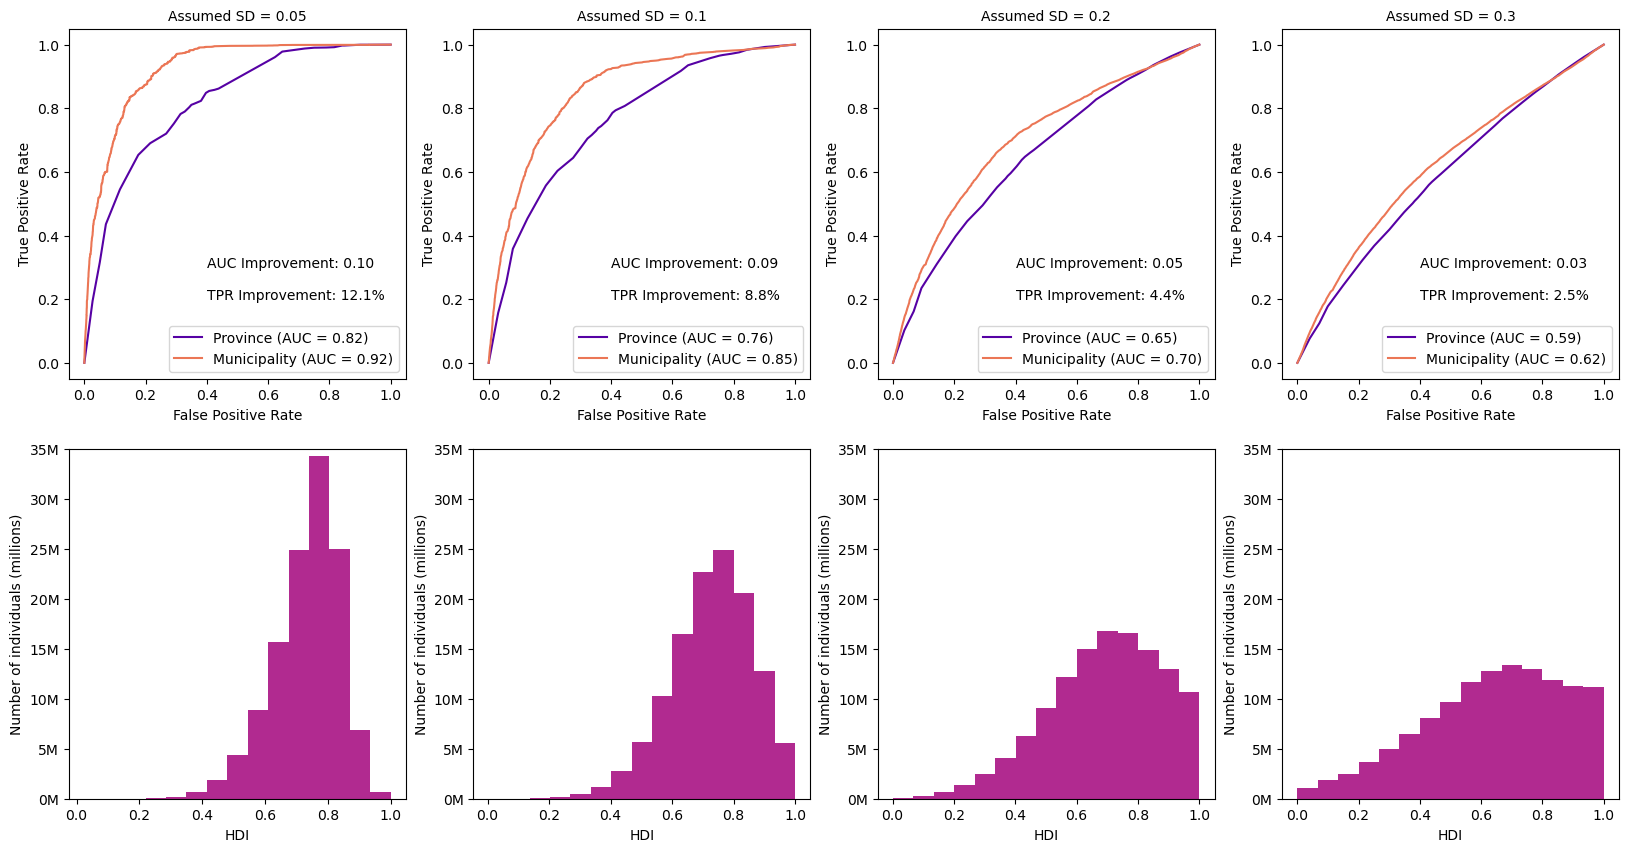

In [16]:
fig, ax = plt.subplots(2,len(assumed_true_SDs), figsize=(len(assumed_true_SDs)*5,10))

if len(assumed_true_SDs)==1:
    ax = ax.reshape(-1,1)

tps_adm1 = []
tps_adm2 = []

for j, assumed_true_sd in enumerate(assumed_true_SDs):

    true_hdi = []
    assumed_hdi_adm1 = []
    assumed_hdi_adm2 = []

    for i,row in data.iterrows():
        a, b = (0 - row["mhdi_adm2 true"]) /assumed_true_sd, (1- row["mhdi_adm2 true"]) / assumed_true_sd
        
        true_hdi.append(truncnorm(a=a, 
                                  b=b,
                                  loc=row["mhdi_adm2 true"], 
                                  scale = assumed_true_sd).rvs(row["pop_downscale"],random_state=0))

        assumed_hdi_adm1.append(np.full(row["pop_downscale"],row["adm1_truth"]))
        assumed_hdi_adm2.append(np.full(row["pop_downscale"],row["adm2_pred"]))

    true_hdi = np.hstack(true_hdi)
    assumed_hdi_adm1 = np.hstack(assumed_hdi_adm1)
    assumed_hdi_adm2 = np.hstack(assumed_hdi_adm2)

    true_thresh = np.quantile(true_hdi, poor_quantile)
    true_poor = true_hdi <= true_thresh
    #assert true_poor.sum() == target_pop # Check that true poor matches expected val

    adm1_thresh = np.quantile(assumed_hdi_adm1, target_quantile)
    adm1_assumed_poor = assumed_hdi_adm1 < adm1_thresh

    additional = assumed_hdi_adm1 == adm1_thresh ## Problem is that we over allocate on the margin. Drop at random.
    quota = target_pop - adm1_assumed_poor.sum()
    additional = drop_at_random_for_quota(additional, quota) #Limit the marginal additions using randomization

    adm1_assumed_poor = adm1_assumed_poor | additional
    #assert adm1_assumed_poor.sum() == target_pop # Check that adm1 targeted matches expected val

    adm2_thresh = np.quantile(assumed_hdi_adm2, target_quantile)
    adm2_assumed_poor = assumed_hdi_adm2 < adm2_thresh

    additional = assumed_hdi_adm2 == adm2_thresh ## Problem is that we over allocate on the margin. Drop at random.
    quota = target_pop - adm2_assumed_poor.sum()
    additional = drop_at_random_for_quota(additional, quota) #Limit the marginal additions using randomization

    adm2_assumed_poor = adm2_assumed_poor | additional
    #assert adm2_assumed_poor.sum() == target_pop # Check that adm1 targeted matches expected val


    tp_adm1 = (adm1_assumed_poor & true_poor).sum()/target_pop * 100
    tp_adm2 = (adm2_assumed_poor & true_poor).sum()/target_pop * 100
    tp_diff = tp_adm2 - tp_adm1
    
    print("tp_adm1:", tp_adm1)
    print("tp_adm2:", tp_adm2)
    
    tps_adm1.append(tp_adm1)
    tps_adm2.append(tp_adm2)
#     fp_adm1 = (adm1_assumed_poor & ~ true_poor).sum()/target_pop * 100
#     fp_adm2 = (adm2_assumed_poor & ~ true_poor).sum()/target_pop * 100
#     fp_diff = fp_adm2 - fp_adm1
    
    y = np.array(true_poor)
    x = np.array(assumed_hdi_adm1).reshape(-1,1)

    lm = LogisticRegression().fit(x,y)

    pred = lm.predict_proba(x)[:, 1]
    roc_auc_adm1 = roc_auc_score(y, pred)

    fpr, tpr, thresholds = roc_curve(y, pred)
    
    display_adm1 = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc_adm1, estimator_name='Province', 
                                   )

    x = np.array(assumed_hdi_adm2).reshape(-1,1)
    lm = LogisticRegression().fit(x,y)

    pred = lm.predict_proba(x)[:, 1]
    roc_auc_adm2 = roc_auc_score(y, pred)

    fpr, tpr, thresholds = roc_curve(y, pred)

    display_adm2 = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc_adm2, estimator_name='Municipality')

    auc_dif = roc_auc_adm2-roc_auc_adm1
    

    display_adm1.plot(ax=ax[0,j], color=adm1_color)
    display_adm2.plot(ax=ax[0,j], color=adm2_color)
    
    if print_additional_text:
        ax[0,j].text(.4,.3,"AUC Improvement: {:.2f}".format(auc_dif))
        ax[0,j].text(.4,.2,"TPR Improvement: {:.1f}%".format(tp_diff))
        
    ax[0,j].set_title("Assumed SD = {}".format(assumed_true_sd), size=10)
    
    ax[1,j].hist(true_hdi,bins=15, color = col(0.4), density=False)
    ax[1,j].yaxis.set_major_formatter(formatter)
    ax[1,j].set_ylim(0,35e4)
    ax[1,j].set_ylabel("Number of individuals (millions)")
    ax[1,j].set_xlabel("HDI")

#fig.savefig(repo_dir + "figures/" + "fig5v2_ROC.pdf", dpi=300)
#fig.savefig(repo_dir + "figures/" + "SI_ROC_multipanel.pdf", dpi=300)

### Run alternative where Accuracy is on Y axis and SD is on X axis

In [17]:
SDs = np.arange(0.01,.52,.02)

tps_adm1 = []
tps_adm2 = []
tps_diff = []

for assumed_true_sd in SDs:
    print(assumed_true_sd)
    true_hdi = []
    assumed_hdi_adm1 = []
    assumed_hdi_adm2 = []

    for i,row in data.iterrows():
        a, b = (0 - row["mhdi_adm2 true"]) /assumed_true_sd, (1- row["mhdi_adm2 true"]) / assumed_true_sd
        true_hdi.append(truncnorm(a=a, b=b,loc=row["mhdi_adm2 true"], 
                                  scale = assumed_true_sd).rvs(row["pop_downscale"],random_state=0))

        assumed_hdi_adm1.append(np.full(row["pop_downscale"],row["adm1_truth"]))
        assumed_hdi_adm2.append(np.full(row["pop_downscale"],row["adm2_pred"]))

    true_hdi = np.hstack(true_hdi)
    assumed_hdi_adm1 = np.hstack(assumed_hdi_adm1)
    assumed_hdi_adm2 = np.hstack(assumed_hdi_adm2)

    true_thresh = np.quantile(true_hdi, poor_quantile)
    true_poor = true_hdi <= true_thresh
    #assert true_poor.sum() == target_pop # Check that true poor matches expected val

    adm1_thresh = np.quantile(assumed_hdi_adm1, poor_quantile)
    adm1_assumed_poor = assumed_hdi_adm1 < adm1_thresh

    additional = assumed_hdi_adm1 == adm1_thresh ## Problem is that we over allocate on the margin. Drop at random.
    quota = target_pop - adm1_assumed_poor.sum()
    additional = drop_at_random_for_quota(additional, quota) #Limit the marginal additions using randomization

    adm1_assumed_poor = adm1_assumed_poor | additional
    #assert adm1_assumed_poor.sum() == target_pop # Check that adm1 targeted matches expected val

    adm2_thresh = np.quantile(assumed_hdi_adm2, poor_quantile)
    adm2_assumed_poor = assumed_hdi_adm2 < adm2_thresh

    additional = assumed_hdi_adm2 == adm2_thresh## Problem is that we over allocate on the margin. Drop at random.
    quota = target_pop - adm2_assumed_poor.sum()
    additional = drop_at_random_for_quota(additional, quota) #Limit the marginal additions using randomization

    adm2_assumed_poor = adm2_assumed_poor | additional
    #assert adm2_assumed_poor.sum() == target_pop # Check that adm1 targeted matches expected val
    
    tp_adm1 = (adm1_assumed_poor & true_poor).sum()/target_pop * 100
    tp_adm2 = (adm2_assumed_poor & true_poor).sum()/target_pop * 100

    tp_diff = tp_adm2 - tp_adm1
    
    tps_adm1.append(tp_adm1)
    tps_adm2.append(tp_adm2)
    tps_diff.append(tp_diff)




0.01
0.03
0.049999999999999996
0.06999999999999999
0.08999999999999998
0.10999999999999997
0.12999999999999998
0.15
0.16999999999999998
0.18999999999999997
0.20999999999999996
0.22999999999999998
0.24999999999999997
0.26999999999999996
0.29
0.30999999999999994
0.32999999999999996
0.35
0.36999999999999994
0.38999999999999996
0.4099999999999999
0.42999999999999994
0.44999999999999996
0.4699999999999999
0.48999999999999994
0.5099999999999999


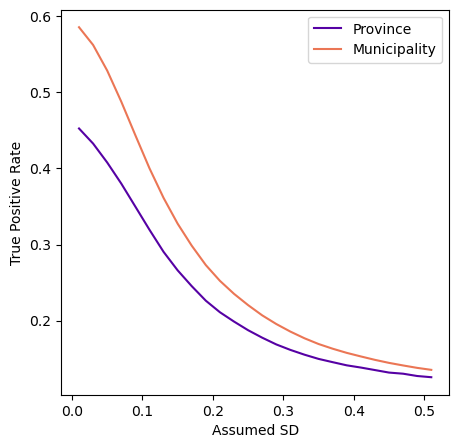

In [18]:
fig, ax = plt.subplots(figsize = (5,5))

ax.plot(SDs,np.array(tps_adm1)/100,label = "Province", color=adm1_color)
ax.plot(SDs,np.array(tps_adm2)/100,label = "Municipality", color=adm2_color)

ax.set_ylabel("True Positive Rate")
ax.set_xlabel("Assumed SD")

ax.legend()

fig.savefig(repo_dir + "figures/" + "fig5v2_Accuracy_and_SD.pdf", dpi=300)

### Now create target maps

Replicating the targeting maps requires that geoBoundaries and ADM1 shapefiles be downloaded.

In [19]:
data.head()

,shapeID,shapeName,shapeGroup,ADM1_shapeID,census_code,population,code,name,mhdi_adm2 true,adm2_pred,GDL_ADM1,adm1_truth,within_adm0_true,within_adm0_pred,adm1_pred_mean,adm1_true_mean,within_adm1_pred,within_adm1_true,pop_downscale
0,MEX-ADM2-3_0_0-B1,Asientos,MEX,MEX-ADM1-3_0_0-B1,01002,50839,01002,Asientos,0.699480,0.780335,MEXr101,0.797,0.064348,0.030796,0.797,0.735634,-0.016665,-0.036154,508
1,MEX-ADM2-3_0_0-B2,San Francisco de los Romo,MEX,MEX-ADM1-3_0_0-B1,01011,41657,01011,San Francisco de los Romo,0.747688,0.795573,MEXr101,0.797,0.112555,0.046034,0.797,0.735634,-0.001427,0.012054,417
2,MEX-ADM2-3_0_0-B3,Rincón de Romos,MEX,MEX-ADM1-3_0_0-B1,01007,53217,01007,Rincón de Romos,0.749543,0.802995,MEXr101,0.797,0.114411,0.053456,0.797,0.735634,0.005995,0.013909,532
3,MEX-ADM2-3_0_0-B4,San José de Gracia,MEX,MEX-ADM1-3_0_0-B1,01008,9662,01008,San José de Gracia,0.723528,0.789482,MEXr101,0.797,0.088395,0.039943,0.797,0.735634,-0.007518,-0.012106,97
4,MEX-ADM2-3_0_0-B5,Jesús María,MEX,MEX-ADM1-3_0_0-B1,01005,121350,01005,Jesús María,0.750694,0.814327,MEXr101,0.797,0.115562,0.064788,0.797,0.735634,0.017327,0.015060,1214


In [20]:
adm2_shp = gpd.read_file(data_dir + "raw/geoBoundaries/geoBoundariesCGAZ_ADM2.geojson")[["shapeID","geometry"]]

In [21]:
adm2_shp = adm2_shp.to_crs("ESRI:54030")

In [22]:
data = gpd.GeoDataFrame(data.merge(adm2_shp,"left", on="shapeID"), crs="ESRI:54030")

In [23]:
mex_full_shp = adm2_shp[adm2_shp["shapeID"].str.startswith("MEX")]

In [24]:
mex_adm1 = pd.read_pickle(data_dir + "/int/GDL_HDI/HDI_ADM1_shapefile_clean.p")
mex_adm1 = mex_adm1.to_crs("ESRI:54030")
mex_adm1 = mex_adm1[mex_adm1["iso_code"] == "MEX"]
mex_adm1 = mex_adm1.merge(data.groupby("GDL_ADM1")["adm1_truth"].first(),"left",
                          left_index=True, right_index=True)

In [25]:
vmin = data["adm2_pred"].min()
vmax = data["adm2_pred"].max()

In [26]:
cmap = "plasma"
plt.rcParams.update({'hatch.color': 'lightgrey'})
rasterized = True

In [27]:
adm1_thresh
adm2_thresh

0.7321812362151133

In [28]:
#matplotlib.rc('font', **{'size'   : 12})

In [29]:
adm2_targ = gpd.GeoDataFrame(data[data["adm2_pred"] < adm2_thresh])
adm2_marg = gpd.GeoDataFrame(data[data["adm2_pred"] == adm2_thresh])
             
adm1_targ = gpd.GeoDataFrame(mex_adm1[mex_adm1["adm1_truth"] < adm1_thresh])
adm1_marg = gpd.GeoDataFrame(mex_adm1[mex_adm1["adm1_truth"] == adm1_thresh])

/home/lsherman/miniconda3/envs/hdi/lib/python3.7/site-packages/ipykernel_launcher.py:56: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


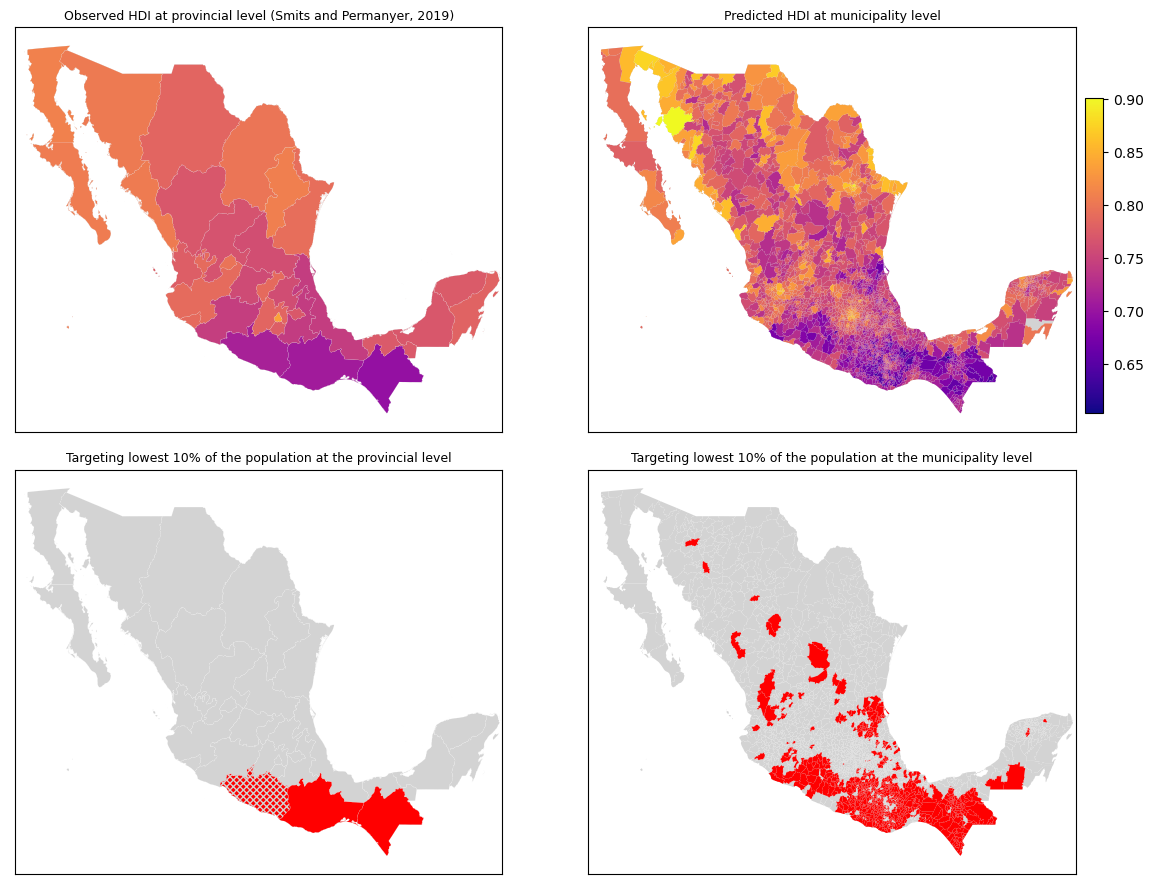

In [32]:
fig, ax = plt.subplots(2,2, figsize=(12,9))

mex_adm1.plot(color="lightgrey", ax=ax[0,0], rasterized=rasterized)
mex_adm1.plot(column = "adm1_truth", cmap=cmap, vmin=vmin, vmax=vmax, ax=ax[0,0], rasterized=rasterized)
mex_adm1.boundary.plot(edgecolor="white", linewidth=.06,ax=ax[0,0],rasterized=rasterized)

mex_full_shp.plot(color="lightgrey", ax=ax[0,1],rasterized=rasterized)
data.plot(column = "adm2_pred", cmap=cmap, vmin=vmin, vmax=vmax, ax=ax[0,1],rasterized=rasterized)
mex_full_shp.boundary.plot(edgecolor="white", linewidth=.015,ax=ax[0,1],rasterized=rasterized)

mex_adm1.plot(color="lightgrey",ax=ax[1,0],rasterized=rasterized)
adm1_marg.plot(color="red",
               #hatch="XXXXX", 
               hatch="xxxxx", 
               ax=ax[1,0],
               rasterized=rasterized)
adm1_targ.plot(color="red", ax=ax[1,0],rasterized=rasterized)
mex_adm1.boundary.plot(edgecolor="white", linewidth=.06,ax=ax[1,0],rasterized=rasterized)

mex_full_shp.plot(color="lightgrey", ax=ax[1,1],rasterized=rasterized)
adm2_marg.plot(color="red", 
               hatch="--", 
               ax=ax[1,1],rasterized=False)
adm2_targ.plot(color="red", ax=ax[1,1],rasterized=rasterized)
mex_full_shp.boundary.plot(edgecolor="white", linewidth=.015,ax=ax[1,1],rasterized=rasterized)

ax[0,0].xaxis.set_visible(False)
ax[0,0].yaxis.set_visible(False)
ax[1,0].xaxis.set_visible(False)
ax[1,0].yaxis.set_visible(False)
ax[0,1].xaxis.set_visible(False)
ax[0,1].yaxis.set_visible(False)
ax[1,1].xaxis.set_visible(False)
ax[1,1].yaxis.set_visible(False)

cax = fig.add_axes([.95, 0.535, 0.015, 0.35]) # X center, Y center, cbar width, cbar height
sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=vmin, vmax=vmax))
sm._A = []
fig.colorbar(sm, cax=cax)

ax[0,0].set_title("Observed HDI at provincial level (Smits and Permanyer, 2019)", size=9)
ax[0,1].set_title("Predicted HDI at municipality level",size=9)
ax[1,0].set_title("Targeting lowest 10% of the population at the provincial level", size=9)
ax[1,1].set_title("Targeting lowest 10% of the population at the municipality level", size=9)

ax[0,0].set_xlim(-106_00000,-802_0000)
ax[0,1].set_xlim(-106_00000,-802_0000)
ax[1,0].set_xlim(-106_00000,-802_0000)
ax[1,1].set_xlim(-106_00000,-802_0000)

#ax[1,1].scatter(adm2_marg.centroid.x,adm2_marg.centroid.y, s=.7)
# red_patch = mpatches.Patch(color='red', label='Targeted districts')
# hatch_patch = mpatches.Patch(color='red', hatch = "XXXX", label='Marginally targeted district')
# fig.legend(handles=[red_patch,hatch_patch], loc="lower right")

fig.tight_layout()
fig.savefig(repo_dir + "figures/" + "fig5v2_mexico_target_maps.pdf", dpi=300)